In [60]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
import audiomentations
#from audiomentations import Compose, AddGaussianNoise, PitchShift
#import torch_audiomentations
from torch_audiomentations import Compose, PitchShift, TimeInversion
import tensorboard
from torch.utils.tensorboard import SummaryWriter
import torchaudio
import numpy as np
import sys

sys.path.insert(0, '../src')
from segmentation import segment_cough


WRITER_PATH ="../logs/CNN"



In [61]:
# Adapted from https://github.com/musikalkemist/pytorchforaudio
class CoughDataset(Dataset):

    def __init__(self,
                 annotations_df,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device,
                #  segment=False,
                 augment=False,
                ):
        self.annotations = annotations_df
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.label_dict = {'healthy':0, 'symptomatic':1, 'COVID-19':2}
        self.label_weights = self._calculate_weights(annotations_df)
        
        # self.do_segment = segment

        # self.segmentation = segment_cough

        self.do_augment = augment
        # self.augmentations = Compose(
        #         [
        #             AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.05, p=0.5),
        #             PitchShift(min_semitones=-8, max_semitones=8, p=0.5)
        #         ]
        # )
        self.augmentations = Compose(
            transforms=[
                PitchShift(
                    mode = "per_example",
                    p=0.5,
                    sample_rate=self.target_sample_rate
                    ),
                TimeInversion(
                    mode = "per_example",
                    p=0.5,
                ),
            ]
        )


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self.label_dict[self._get_audio_sample_label(index)]
        signal, sr = torchaudio.load(audio_sample_path)

        # if self.do_segment:
        #     segments, segment_mask = self.segmentation(signal.numpy()[0], float(sr))
        #     #print('segment length: ', len(segments))
        #     if len(segments) > 0:
        #         signal = torch.tensor(segments[0])
        #         signal = signal.unsqueeze(0)
        #     else:
        #         signal = signal
        #     #print('signal in self.do_segment: ', signal)

        
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)

        if self.do_augment:
            #signal = torch.from_numpy(self.augmentations(signal.numpy(), sr))
            # print('signal shape: ', signal.shape)
            # print('sample rate: ', sr)
            # print('target sample rate: ', self.target_sample_rate)
            # add a 1 in front of the signal array
            signal = signal.unsqueeze(0)
            signal = self.augmentations(signal, self.target_sample_rate)
            # remove the 1 in front of the signal array
            signal = signal.squeeze(0)
        

        signal = self.transformation(signal)

        
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        # print('resampled signal')
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0])+".wav"
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 9]

    def _calculate_weights(self, annotation_df):
        counts = annotation_df["status"].value_counts()
        total = len(annotation_df)
        weights = (1-(counts/total))
        weights /= weights.sum()
        return torch.FloatTensor(weights)




In [62]:
AUDIO_DIR = "../valid_data/"
SAMPLE_RATE = 16000
NUM_SAMPLES = SAMPLE_RATE*10

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
# print(f"Using device {device}")

# train_df = pd.read_parquet(os.path.join(AUDIO_DIR, "train.parquet.gzip"))
# val_df = pd.read_parquet(os.path.join(AUDIO_DIR, "val.parquet.gzip"))
# test_df = pd.read_parquet(os.path.join(AUDIO_DIR, "test.parquet.gzip"))

# train_df = pd.read_parquet(os.path.join(AUDIO_DIR, "train_edited.parquet.gzip"))
# val_df = pd.read_parquet(os.path.join(AUDIO_DIR, "val_edited.parquet.gzip"))
# test_df = pd.read_parquet(os.path.join(AUDIO_DIR, "test_edited.parquet.gzip"))

train_df = pd.read_parquet(os.path.join(AUDIO_DIR, "train_balanced.parquet.gzip"))
val_df = pd.read_parquet(os.path.join(AUDIO_DIR, "val_balanced.parquet.gzip"))
test_df = pd.read_parquet(os.path.join(AUDIO_DIR, "test_balanced.parquet.gzip"))


# print(f"There are {len(usd)} samples in the dataset.")
# signal, label = usd[0]

In [63]:
class CNNNetwork(torch.nn.Module):

    def __init__(self, drop_p=0.2):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16),
            nn.Dropout(p=drop_p)

        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(32),
            nn.Dropout(p=drop_p)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(64),
            nn.Dropout(p=drop_p)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(128),
            nn.Dropout(p=drop_p)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(31744, 3)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_data):
        #nomralization
        std = input_data.std()
        input_data -= input_data.mean()
        input_data /= std
        
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions
    



In [64]:
def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    print('train_dataloader finished: ', train_dataloader)
    return train_dataloader

def count_correct(logits, y_true):
    y_pred = torch.argmax(logits, axis = 1)
    return torch.sum(y_pred==y_true)

def train_single_epoch(model, train_data_loader, val_data_loader, loss_fn, optimiser, device):
    total_loss = 0.0
    correct_pred = 0.0
    total_pred = 0
    for x_batch, y_batch in tqdm(train_data_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # calculate loss
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        
        correct_pred += count_correct(y_pred, y_batch)
        total_pred += y_batch.shape[0]

        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        total_loss += loss.item()
        
    print(f"Training loss: {total_loss}, Training accuracy : {correct_pred/total_pred}")
    train_loss, train_acc = total_loss, correct_pred/total_pred
    
    total_loss = 0.0
    correct_pred = 0.0
    total_pred = 0
    for x_batch, y_batch in tqdm(val_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item() 
            
        correct_pred += count_correct(y_pred, y_batch)
        total_pred += y_batch.shape[0]
        
    print(f"Validataion loss: {total_loss}, Validation accuracy : {correct_pred/total_pred}")
    val_loss, val_acc = total_loss, correct_pred/total_pred

    return train_loss, train_acc, val_loss, val_acc

    
def train(model, train_data_loader, val_data_loader, loss_fn, optimiser, device, epochs):
    writer = SummaryWriter(WRITER_PATH)
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_loss, train_acc, val_loss, val_acc = train_single_epoch(model, train_data_loader, val_data_loader, loss_fn, optimiser, device)
        writer.add_scalar("train/accuracy", train_acc, i)
        writer.add_scalar("train/loss", train_loss, i)
        writer.add_scalar("validation/accuracy", val_acc, i)
        writer.add_scalar("validation/loss", val_loss, i)

        
        path = os.path.join(MODEL_FOLDER, f"epoch_{i}.pth")
        torch.save(model.state_dict(), path)
        print(f"Saved at {path}")
        print("---------------------------")
    print("Finished training")
    print("---------------------------")
    
    
def evaluate(model, eval_data_loader, loss_fn, device):
    print("Evaluating model")
    total_loss = 0.0
    correct_pred = 0.0
    total_pred = 0
    for x_batch, y_batch in tqdm(eval_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # calculate loss
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)

            correct_pred += count_correct(y_pred, y_batch)
            total_pred += y_batch.shape[0]

            total_loss += loss.item()
        
    print(f"Evaluation loss: {total_loss}, Evaluation accuracy : {correct_pred/total_pred}")
    print("---------------------------")

In [65]:
BATCH_SIZE =16
EPOCHS = 50
MODEL_FOLDER = '../models/'

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=128
)

train_data = CoughDataset(train_df,
                        AUDIO_DIR,
                        mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device,
                        )
print('train data: ', train_data)

val_data = CoughDataset(val_df,
                        AUDIO_DIR,
                        mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

test_data = CoughDataset(test_df,
                        AUDIO_DIR,
                        mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

train_dataloader = create_data_loader(train_data, BATCH_SIZE)
val_dataloader = create_data_loader(val_data, BATCH_SIZE)
test_dataloader = create_data_loader(val_data, BATCH_SIZE)

# construct model and assign it to device
model = CNNNetwork().to(device)

# initialise loss funtion + optimiser
#loss_fn = nn.CrossEntropyLoss(weight=train_data.label_weights)
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters())

train data:  <__main__.CoughDataset object at 0x2a5e97c70>
train_dataloader finished:  <torch.utils.data.dataloader.DataLoader object at 0x2a5e99120>
train_dataloader finished:  <torch.utils.data.dataloader.DataLoader object at 0x2a5e9a620>
train_dataloader finished:  <torch.utils.data.dataloader.DataLoader object at 0x2a5e99720>


In [66]:
train(model, train_dataloader, val_dataloader, loss_fn, optimiser, device, EPOCHS)

Epoch 1


100%|██████████| 361/361 [05:38<00:00,  1.07it/s]


Training loss: 248.94485533237457, Training accuracy : 0.8602635264396667


100%|██████████| 41/41 [00:06<00:00,  6.60it/s]


Validataion loss: 27.654162287712097, Validation accuracy : 0.873634934425354
Saved at ../models/epoch_0.pth
---------------------------
Epoch 2


100%|██████████| 361/361 [05:41<00:00,  1.06it/s]


Training loss: 242.4827030301094, Training accuracy : 0.8796809911727905


100%|██████████| 41/41 [00:05<00:00,  7.45it/s]


Validataion loss: 27.920560657978058, Validation accuracy : 0.8907956480979919
Saved at ../models/epoch_1.pth
---------------------------
Epoch 3


100%|██████████| 361/361 [05:28<00:00,  1.10it/s]


Training loss: 236.76550006866455, Training accuracy : 0.8956310749053955


100%|██████████| 41/41 [00:05<00:00,  7.12it/s]


Validataion loss: 27.79117202758789, Validation accuracy : 0.8939157724380493
Saved at ../models/epoch_2.pth
---------------------------
Epoch 4


100%|██████████| 361/361 [05:25<00:00,  1.11it/s]


Training loss: 235.50523167848587, Training accuracy : 0.8992718458175659


100%|██████████| 41/41 [00:05<00:00,  7.25it/s]


Validataion loss: 27.79673081636429, Validation accuracy : 0.8939157724380493
Saved at ../models/epoch_3.pth
---------------------------
Epoch 5


100%|██████████| 361/361 [05:45<00:00,  1.05it/s]


Training loss: 235.7590863108635, Training accuracy : 0.8985783457756042


100%|██████████| 41/41 [00:06<00:00,  6.82it/s]


Validataion loss: 27.75628972053528, Validation accuracy : 0.8954758048057556
Saved at ../models/epoch_4.pth
---------------------------
Epoch 6


100%|██████████| 361/361 [05:43<00:00,  1.05it/s]


Training loss: 237.03465408086777, Training accuracy : 0.8949375748634338


100%|██████████| 41/41 [00:05<00:00,  7.13it/s]


Validataion loss: 27.7342312335968, Validation accuracy : 0.8954758048057556
Saved at ../models/epoch_5.pth
---------------------------
Epoch 7


100%|██████████| 361/361 [05:32<00:00,  1.08it/s]


Training loss: 236.29355019330978, Training accuracy : 0.8970180153846741


100%|██████████| 41/41 [00:05<00:00,  7.04it/s]


Validataion loss: 27.796731293201447, Validation accuracy : 0.8939157724380493
Saved at ../models/epoch_6.pth
---------------------------
Epoch 8


100%|██████████| 361/361 [05:28<00:00,  1.10it/s]


Training loss: 236.41378819942474, Training accuracy : 0.8966712951660156


100%|██████████| 41/41 [00:05<00:00,  7.17it/s]


Validataion loss: 27.60579687356949, Validation accuracy : 0.898595929145813
Saved at ../models/epoch_7.pth
---------------------------
Epoch 9


100%|██████████| 361/361 [05:29<00:00,  1.09it/s]


Training loss: 235.19065523147583, Training accuracy : 0.9001386761665344


100%|██████████| 41/41 [00:05<00:00,  7.29it/s]


Validataion loss: 27.60936725139618, Validation accuracy : 0.898595929145813
Saved at ../models/epoch_8.pth
---------------------------
Epoch 10


100%|██████████| 361/361 [05:34<00:00,  1.08it/s]


Training loss: 235.25652247667313, Training accuracy : 0.8999653458595276


100%|██████████| 41/41 [00:05<00:00,  6.83it/s]


Validataion loss: 27.54673147201538, Validation accuracy : 0.9001560211181641
Saved at ../models/epoch_9.pth
---------------------------
Epoch 11


 85%|████████▌ | 308/361 [05:09<00:53,  1.01s/it]


KeyboardInterrupt: 

In [67]:
evaluate(model, test_dataloader, loss_fn, device)

Evaluating model


100%|██████████| 41/41 [00:07<00:00,  5.48it/s]

Evaluation loss: 27.61043083667755, Evaluation accuracy : 0.898595929145813
---------------------------


In [68]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np

In [69]:
from sklearn.metrics import plot_confusion_matrix

def evaluate_confusion(model, eval_data_loader, device):
    trues = []
    preds =[]
    for x_batch, y_batch in tqdm(eval_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # calculate loss
            y_pred = model(x_batch)


            trues += torch.clamp(y_batch, max=1)


            preds += torch.clamp(torch.argmax(y_pred, axis = 1), max=1)
            
            
    return np.array(trues), np.array(preds)
        




In [70]:
trues, preds = evaluate_confusion(model, test_dataloader, device)

100%|██████████| 41/41 [00:07<00:00,  5.30it/s]


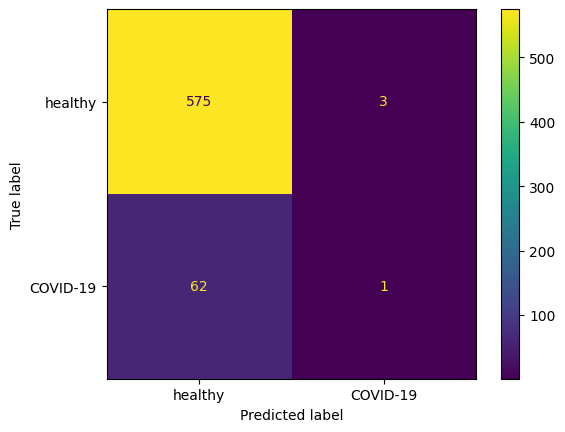

In [71]:
cfm = confusion_matrix(trues, preds)
#ConfusionMatrixDisplay(cfm, display_labels=['healthy', 'symptomatic', 'COVID-19']).plot()
ConfusionMatrixDisplay(cfm, display_labels=['healthy', 'COVID-19']).plot()

In [ ]:
cfm

In [73]:
preds.dtype

dtype('int64')